In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install openpyxl==3.0.0

In [5]:
!pip install nlpaug
!pip install openpyxl
!pip install -q xlrd
!pip install -q xlrd
!pip install -U -q PyDrive


In [6]:
import time
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
#import stanza

# from custom_preprocessing import CustomPreProcessing
# from custom_preprocessing import PreProcessing


import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.utils import np_utils

from xgboost import XGBClassifier


import string
#import fasttext
#import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
nltk.download('words')
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
import time
from nltk.corpus import stopwords
nltk.download('stopwords')
#", ".join(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import random
import re
import pandas as pd
from nltk import sent_tokenize
from tqdm import tqdm
from albumentations.core.transforms_interface import DualTransform, BasicTransform
import openpyxl
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA


0it [00:00, ?it/s]


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TicketAssigningNLP/input_data (1).xlsx', index_col=0) 

In [8]:
df.reset_index(inplace = True)

In [9]:
df

Short description  ... Assignment group
0                                           login issue  ...            GRP_0
1                                               outlook  ...            GRP_0
2                                    cant log in to vpn  ...            GRP_0
3                         unable to access hr_tool page  ...            GRP_0
4                                          skype error   ...            GRP_0
...                                                 ...  ...              ...
8495                  emails not coming in from zz mail  ...           GRP_29
8496                           telephony_software issue  ...            GRP_0
8497  vip2: windows password reset for tifpdchb pedx...  ...            GRP_0
8498                     machine nÃ£o estÃ¡ funcionando  ...           GRP_62
8499  an mehreren pc`s lassen sich verschiedene prgr...  ...           GRP_49

[8500 rows x 4 columns]

In [10]:
df_processing = df.copy()
df_processing['text'] = df['Short description']+" "+df["Description"]
df_processing = df_processing[['text','Assignment group']]
#df_processing['Assignment group'].replace('GRP_',' ',inplace=True)
df_processing['Assignment group']= df_processing['Assignment group'].str.replace('GRP','')
df_processing['Assignment group']= df_processing['Assignment group'].str.replace('_','')
df_processing['Assignment group']= df_processing['Assignment group'].astype(int)
df_processing['text']= df_processing['text'].astype(str)

In [11]:
df_processing['Assignment group'].value_counts()

0     3976
8      661
24     289
12     257
9      252
      ... 
64       1
67       1
35       1
70       1
73       1
Name: Assignment group, Length: 74, dtype: int64

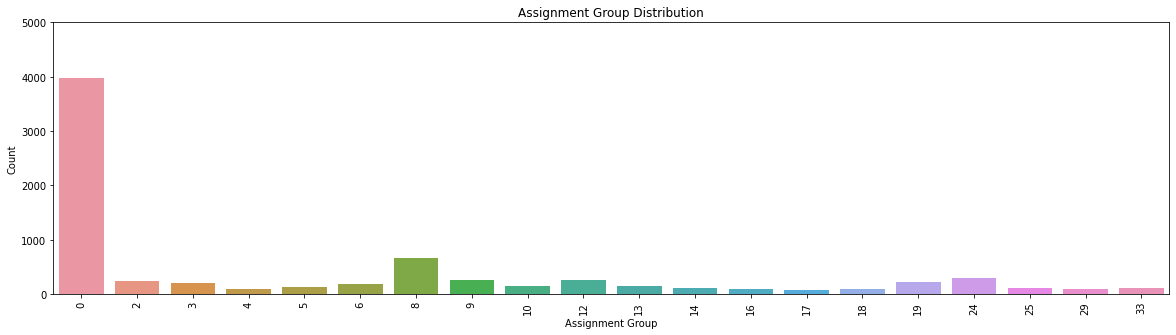

In [12]:
top_20 = df_processing['Assignment group'].value_counts().nlargest(20).reset_index()
plt.subplots(figsize=(20,5))
sns.barplot(x='index', y='Assignment group', data=top_20)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Assignment Group Distribution')
plt.ylim(0, 5000)
plt.show();

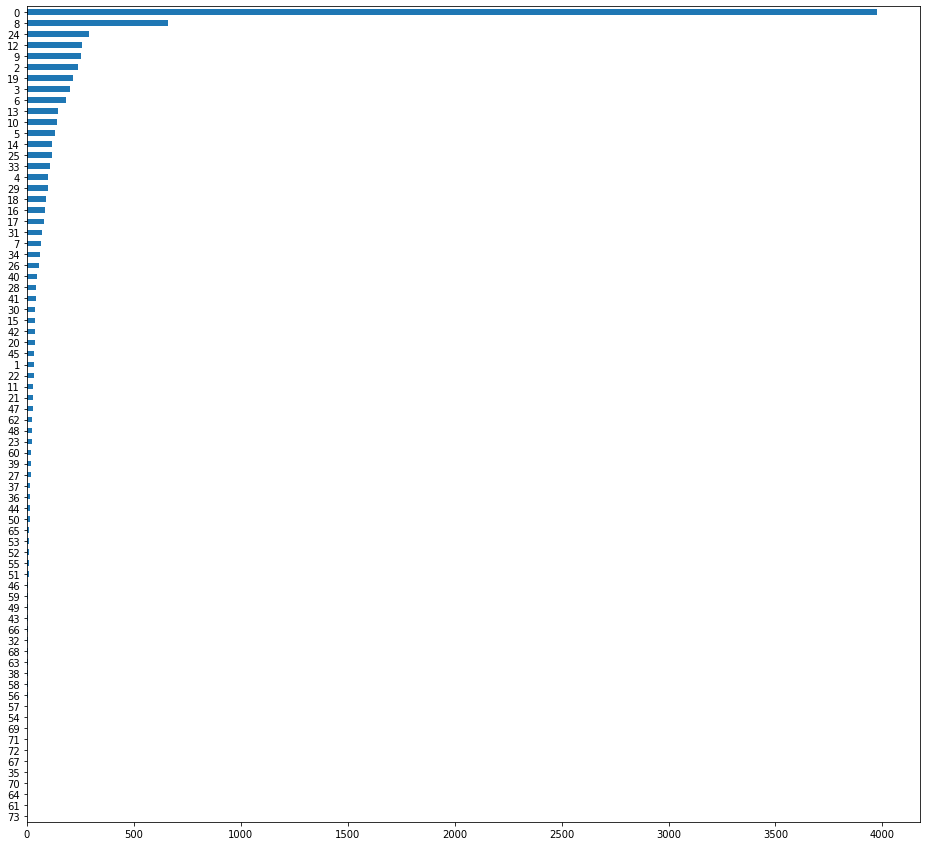

In [13]:
#sns.countplot(x = df['Assignment group'].value_counts() )
plt.figure(1,figsize=(16,15))
df_processing['Assignment group'].value_counts().sort_values().plot(kind = 'barh')

In [14]:
value_count_df = df_processing['Assignment group'].value_counts().to_frame().reset_index()
value_count_df ['Per'] = df_processing['Assignment group'].value_counts(normalize=True)

In [15]:
value_count_df.describe()

index  Assignment group        Per
count  74.000000         74.000000  74.000000
mean   36.500000        114.864865   0.013514
std    21.505813        465.747516   0.054794
min     0.000000          1.000000   0.000118
25%    18.250000          5.250000   0.000618
50%    36.500000         26.000000   0.003059
75%    54.750000         84.000000   0.009882
max    73.000000       3976.000000   0.467765

In [16]:
GrpToBeMaintained = value_count_df[value_count_df['Assignment group'] >= 80]['index'].values

In [17]:
value_count_df[value_count_df['Assignment group'] >= 80]

index  Assignment group       Per
0       0              3976  0.467765
1       8               661  0.003647
2      24               289  0.028353
3      12               257  0.023529
4       9               252  0.011765
5       2               241  0.015176
6      19               215  0.021647
7       3               200  0.008000
8       6               184  0.077765
9      13               145  0.029647
10     10               140  0.016471
11      5               129  0.003529
12     14               118  0.030235
13     25               116  0.017059
14     33               107  0.013882
15      4               100  0.004588
16     29                97  0.010000
17     18                88  0.009529
18     16                85  0.010353
19     17                81  0.025294

In [18]:
GrpToBeMaintained

array([ 0,  8, 24, 12,  9,  2, 19,  3,  6, 13, 10,  5, 14, 25, 33,  4, 29,
       18, 16, 17])

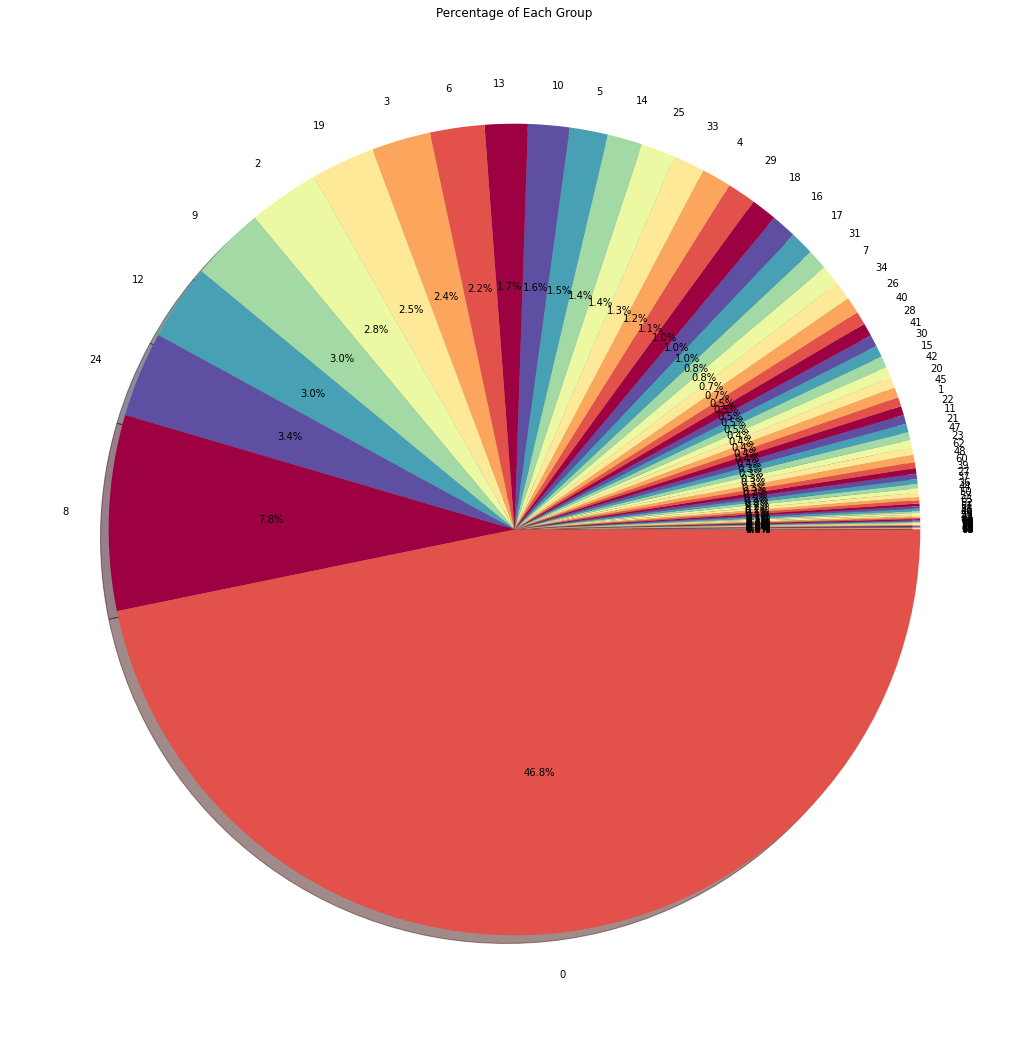

In [19]:
title_rating = df_processing.groupby('Assignment group').agg('count')
rating_labels = title_rating.text.sort_values().index 
rating_counts = title_rating.text.sort_values()
plt.figure(1, figsize=(40,70))
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(the_grid[0, 1], aspect=1, title='Percentage of Each Group')
type_show_ids = plt.pie(rating_counts, labels=rating_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [20]:
def assignGroup(x):
  if x in GrpToBeMaintained:
    val = x
  else:
    val = 100
  return val


In [21]:
df_sampled = df_processing[ df_processing['Assignment group'].isin(GrpToBeMaintained)]

In [22]:
df_sampled .isnull().sum()

text                0
Assignment group    0
dtype: int64

In [23]:
df_sampled

text  Assignment group
0     login issue -verified user details.(employee# ...                 0
1     outlook _x000D_\n_x000D_\nreceived from: hmjdr...                 0
2     cant log in to vpn _x000D_\n_x000D_\nreceived ...                 0
3     unable to access hr_tool page unable to access...                 0
4                             skype error  skype error                  0
...                                                 ...               ...
8493  erp fi  - ob09, two accounts to be added i am ...                10
8494  tablet needs reimaged due to multiple issues w...                 3
8495  emails not coming in from zz mail _x000D_\n_x0...                29
8496  telephony_software issue telephony_software issue                 0
8497  vip2: windows password reset for tifpdchb pedx...                 0

[7481 rows x 2 columns]

In [24]:
def wl(text):
    return len(text.split(" "))
fig_df = pd.DataFrame()
fig_df['word_length']=df_sampled['text'].apply(wl)
fig_df['char_length']=df_sampled['text'].apply(len)
fig_df['text']= df_sampled['text']
fig_df['Assignment group']= df_sampled['Assignment group']

In [25]:
fig_df[["text","word_length"]].sort_values(by = "word_length",ascending = False).head(10)

text  word_length
7345  security incidents - ( sw #in33501789 ) : broa...         1431
4089  security incidents - ( sw #in33895560 ) : mage...         1408
7989  security incidents - ( dsw #in33407676 ) : tra...         1364
7997  security incidents - ( sw #in33544563 ) : poss...         1303
3965  security incidents - ( #in33809307 ) : possibl...         1176
7984  security incidents - ( dsw #in33390850 ) : sus...         1027
7982  security incidents - ( dsw #in33390850 ) : sus...         1027
5092  security incidents - ( #in33578632) : suspicio...          958
5433  security incidents - ( #in33765965 ) : possibl...          934
7647  security incidents - ( #in33578632) : suspicio...          897

In [26]:
fig_df[["text","word_length"]].sort_values(by = "word_length",ascending = True).head(10)

text  word_length
3383      nan            1
4395      nan            1
3906      nan            1
3910      nan            1
3915      nan            1
3921      nan            1
3924      nan            1
4341      nan            1
3432  dds dss            2
1860      s s            2

In [27]:
fig_df[["text","char_length"]].sort_values(by = "char_length",ascending = False).head()

text  char_length
7345  security incidents - ( sw #in33501789 ) : broa...        14544
4089  security incidents - ( sw #in33895560 ) : mage...        12032
7984  security incidents - ( dsw #in33390850 ) : sus...        11372
7989  security incidents - ( dsw #in33407676 ) : tra...        10450
5092  security incidents - ( #in33578632) : suspicio...        10212

In [28]:
fig_df[["text","char_length"]].sort_values(by = "char_length",ascending = True).head()

text  char_length
3924  nan            3
3921  nan            3
3383  nan            3
4341  nan            3
3915  nan            3

In [29]:
df_nan = fig_df.loc[fig_df['word_length'] == 1]
#df.loc[df['column_name'] == some_value]

In [30]:
#df_processing[df_processing['text'].isna()]

df_nan

word_length  char_length text  Assignment group
3383            1            3  nan                 0
3906            1            3  nan                 0
3910            1            3  nan                 0
3915            1            3  nan                 0
3921            1            3  nan                 0
3924            1            3  nan                 0
4341            1            3  nan                 0
4395            1            3  nan                 0

In [31]:
#drop null values

In [32]:
df_sampled.drop(df_nan.index)

text  Assignment group
0     login issue -verified user details.(employee# ...                 0
1     outlook _x000D_\n_x000D_\nreceived from: hmjdr...                 0
2     cant log in to vpn _x000D_\n_x000D_\nreceived ...                 0
3     unable to access hr_tool page unable to access...                 0
4                             skype error  skype error                  0
...                                                 ...               ...
8493  erp fi  - ob09, two accounts to be added i am ...                10
8494  tablet needs reimaged due to multiple issues w...                 3
8495  emails not coming in from zz mail _x000D_\n_x0...                29
8496  telephony_software issue telephony_software issue                 0
8497  vip2: windows password reset for tifpdchb pedx...                 0

[7473 rows x 2 columns]

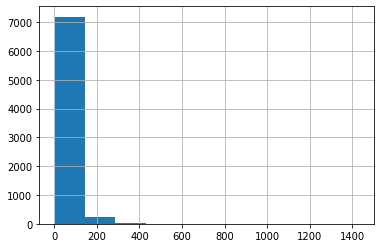

In [33]:
fig_df['word_length'].hist()

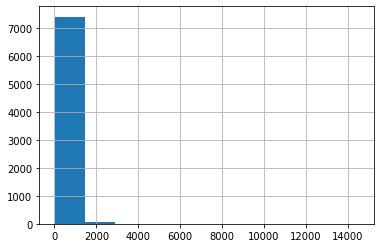

In [34]:
fig_df['char_length'].hist()

In [35]:
fig_df.groupby('Assignment group').agg({'word_length': ['mean', 'min', 'max']})

word_length          
                        mean min   max
Assignment group                      
0                  23.421278   1   478
2                 106.012448   8  1431
3                  41.390000   6   958
4                  54.640000   6   304
5                  37.984496   8   412
6                  27.798913   9   268
8                  75.417549   5   379
9                  29.337302   8   449
10                 34.621429   8   158
12                 47.105058   4  1027
13                 53.903448   4   252
14                 44.381356  10   348
16                 43.164706   9   192
17                 13.358025  10    68
18                 59.704545  10   361
19                 32.004651   4   618
24                 14.650519   8   121
25                 37.612069   6   215
29                 45.072165   7   190
33                 32.121495   4   264

In [36]:
fig_df.groupby('Assignment group').agg({'char_length': ['mean', 'min', 'max']})


char_length           
                        mean min    max
Assignment group                       
0                 176.196932   3   3463
2                 879.921162  37  14544
3                 293.905000  39  10212
4                 362.280000  37   1691
5                 273.480620  89   1784
6                 231.989130  55   1431
8                 462.183056  42   1906
9                 233.777778  53   1999
10                280.885714  55   1059
12                380.424125  29  11372
13                375.827586  31   1607
14                316.254237  47   2075
16                336.400000  67   1525
17                111.839506  82    436
18                424.284091  60   2323
19                248.944186  25   7631
24                114.525952  45   1113
25                312.448276  49   1911
29                334.865979  67   1680
33                237.383178  29   1458

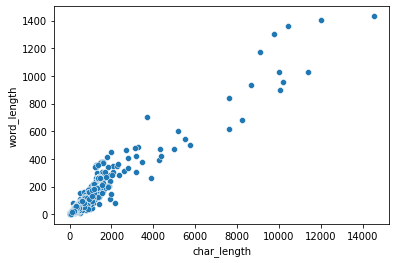

In [37]:
sns.scatterplot(x='char_length',y='word_length',data=fig_df)

In [38]:
stopwords = set(STOPWORDS)

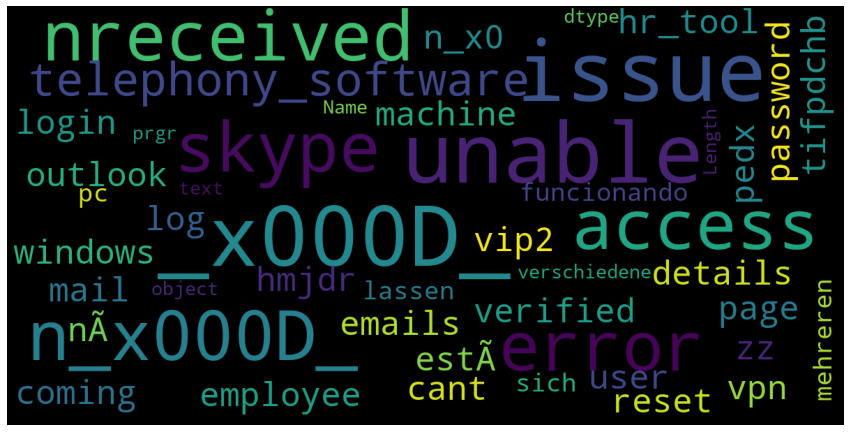

In [39]:


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#show_wordcloud(df['reviews.text'])
show_wordcloud(df_processing['text'])

In [40]:
STOPWORDS = set(STOPWORDS)
words = set(nltk.corpus.words.words())
PUNCT_TO_REMOVE = string.punctuation
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

In [41]:
# Functions for preprocessing
def remove_upper_case( text):
        '''
        Function to transform upper string in title words
        @param text: (str) text 
        @return: (str) text without upper words 
        '''
        sentences = text.split("\n")
        new_sentences = []
        for i in sentences:
            words = text.split()
            stripped = [w.title() if w.isupper() else w for w in words]
            new_sentences.append(" ".join(stripped))
        return "\n".join(new_sentences)
def remove_URL( text):
        '''
        Function to remove url from text.
        @param text: (str) sentence
        @return: (str) clean text
        
        '''
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    
    
def remove_html( text):
        '''
        Function regex to clean text from html balises.
        @param text: (str) sentence 
        @return: (str) clean text 
        '''
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)
    
    

def remove_emoji( text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

def remove_special_char( text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        spcl_char_pattern = re.compile(r'[^`~!@#$%^&*()_+={}\[\]|\\:;“’<,>.?๐฿]*$')
        return spcl_char_pattern.sub(r'',text)
        return spcl_char_pattern.sub(r'', text)



def clean_sent_org(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())
def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words )
    

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))




def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])




def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

#df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))


In [42]:
TEXT = 'text'
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_upper_case)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_URL)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_html)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_emoji)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_special_char)
df_sampled[TEXT] = df_sampled[TEXT].apply(clean_sent)
df_sampled[TEXT] = df_sampled[TEXT].apply( remove_punctuation)
df_sampled[TEXT] = df_sampled[TEXT].apply( remove_stopwords)
df_sampled[TEXT] = df_sampled[TEXT].apply(lemmatize_words)

In [43]:
df_sampled[TEXT] = df_sampled[TEXT].str.strip().replace('', 'NaN')

In [44]:
df_sampled[df_sampled[TEXT]=='NaN']

text  Assignment group
4     NaN                 0
5     NaN                 0
8     NaN                 0
10    NaN                 0
13    NaN                 0
...   ...               ...
8473  NaN                 0
8474  NaN                 0
8485  NaN                 0
8489  NaN                 0
8494  NaN                 3

[1545 rows x 2 columns]

In [45]:
df_sampled = df_sampled[df_sampled[TEXT] != 'NaN']

In [46]:
df_sampled

text  Assignment group
0     login issue user employee manager name check u...                 0
1     outlook receive hello team outlook calendar so...                 0
2     cant log receive log best cant log receive log...                 0
3                      unable access page unable access                 0
7     employment status new non employee enter user ...                 0
...                                                 ...               ...
8492                                             option                 0
8493  fi two add sorry another two need add please c...                10
8495  come mail receive good afternoon send mail ple...                29
8496                                              issue                 0
8497                                     password reset                 0

[5936 rows x 2 columns]

In [47]:
top_20_grp = df_sampled['Assignment group'].value_counts().nlargest(20).index

Word cloud for class  0


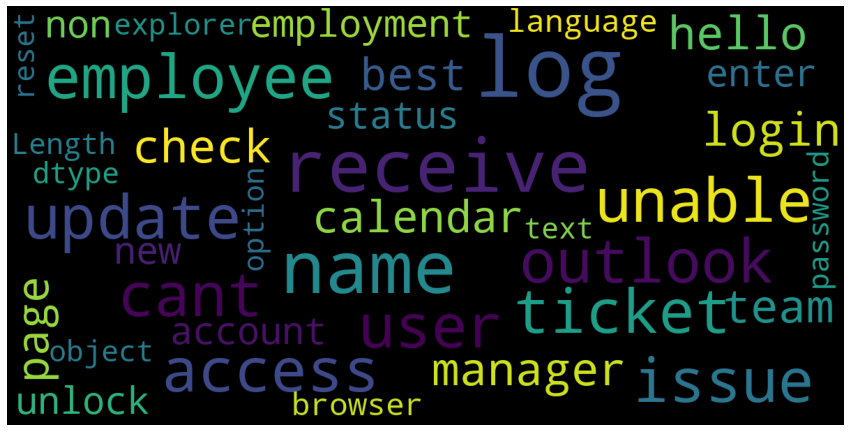

Word cloud for class  8


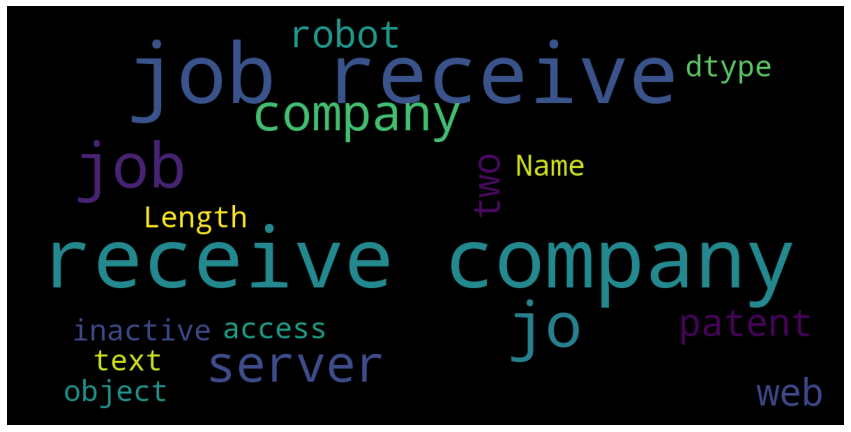

Word cloud for class  12


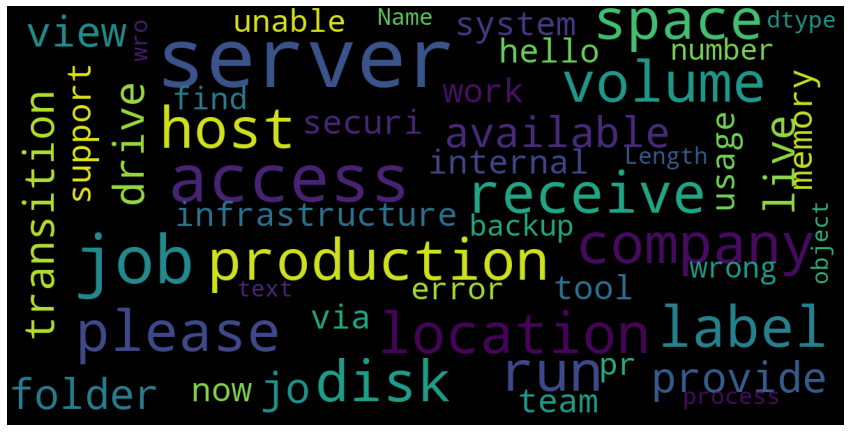

Word cloud for class  9


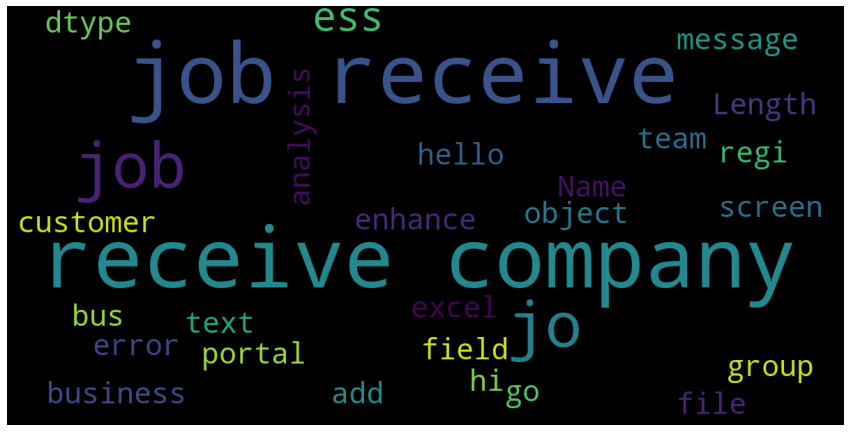

Word cloud for class  2


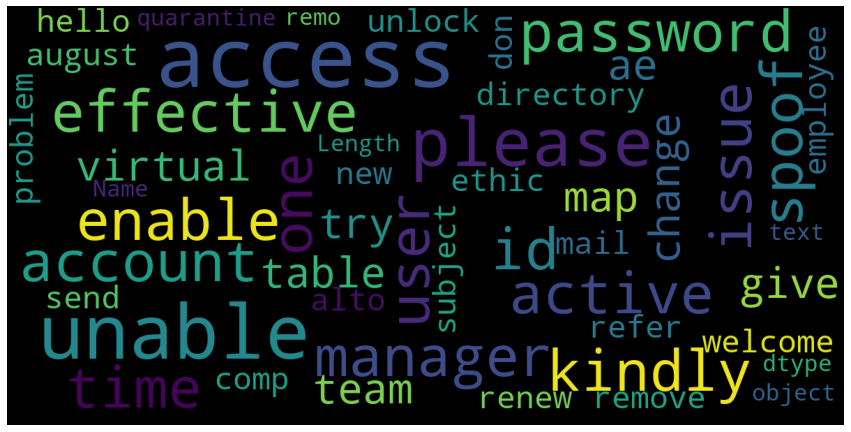

Word cloud for class  24


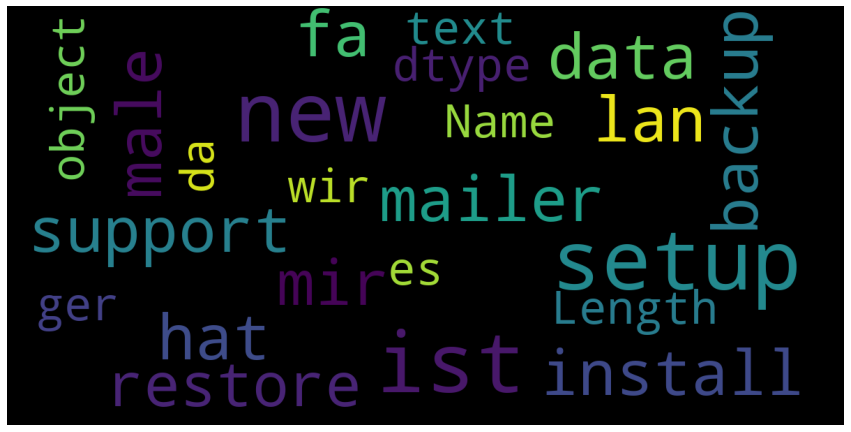

Word cloud for class  6


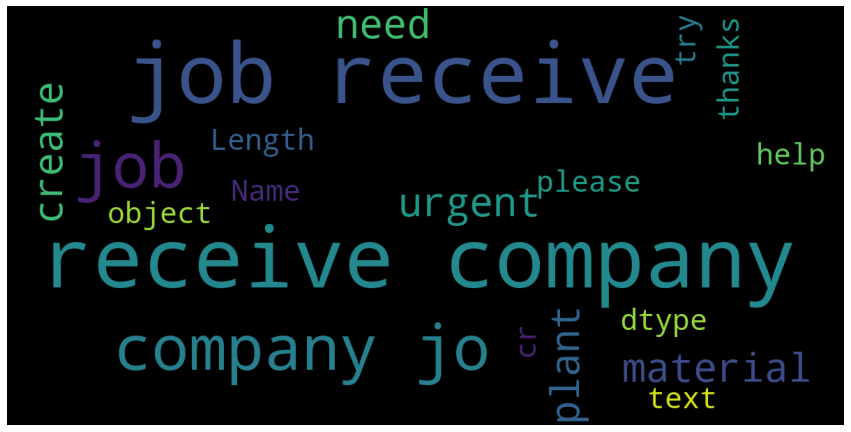

Word cloud for class  3


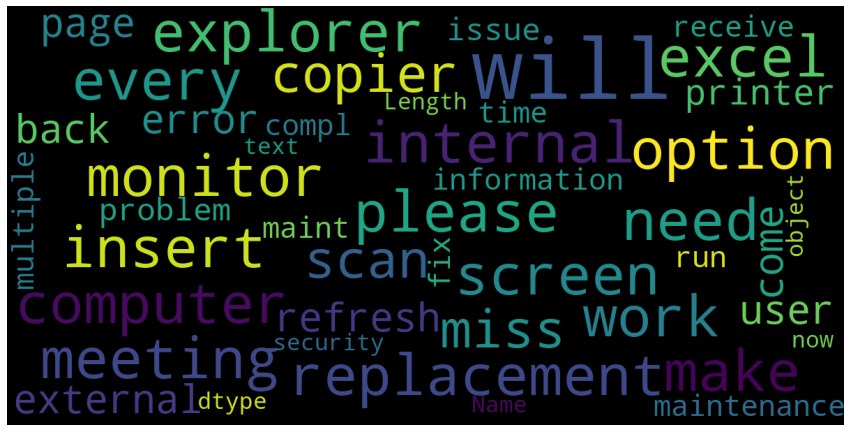

Word cloud for class  19


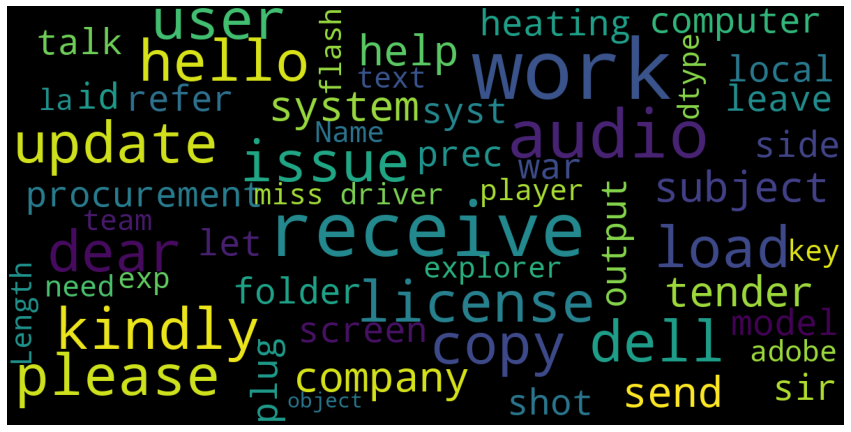

Word cloud for class  13


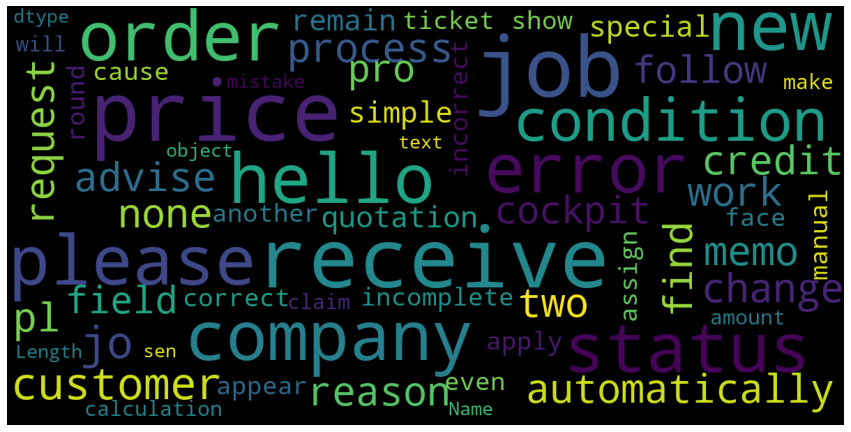

Word cloud for class  10


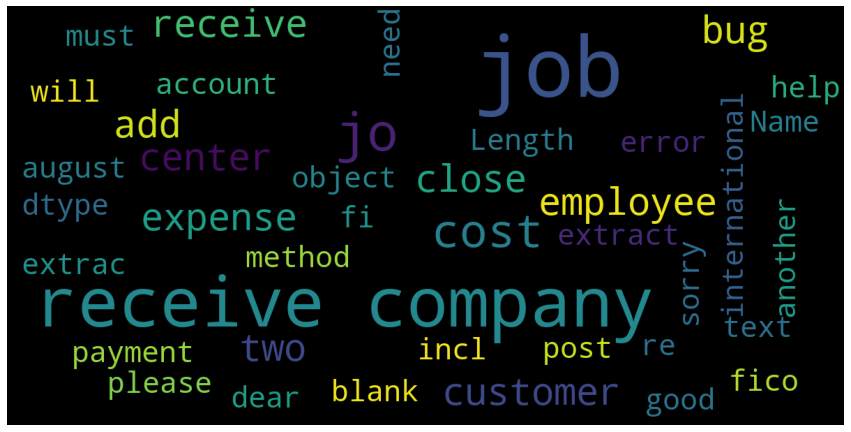

Word cloud for class  5


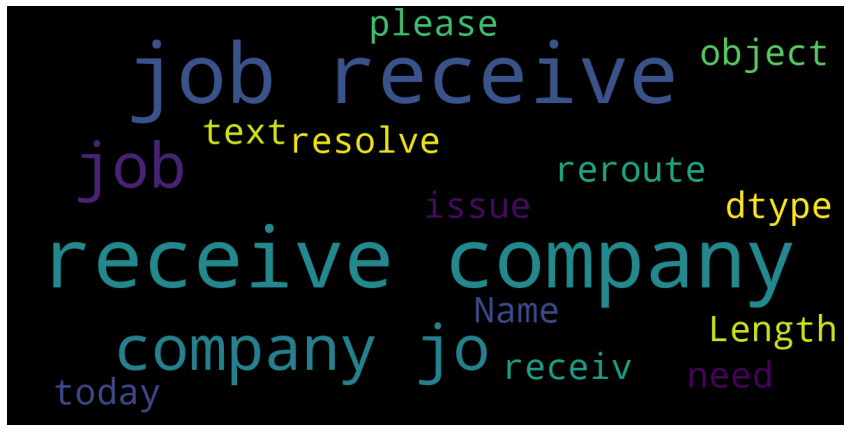

Word cloud for class  14


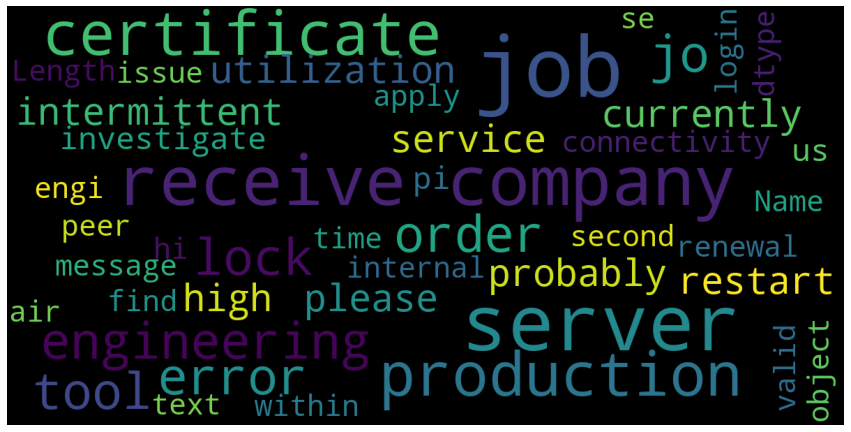

Word cloud for class  25


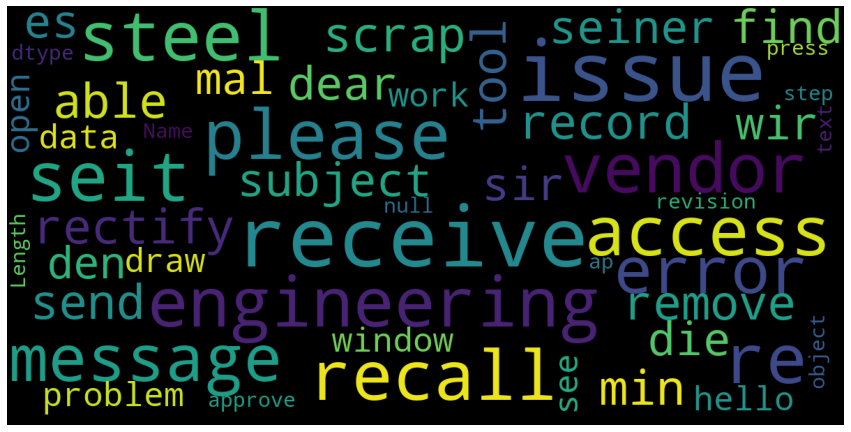

Word cloud for class  4


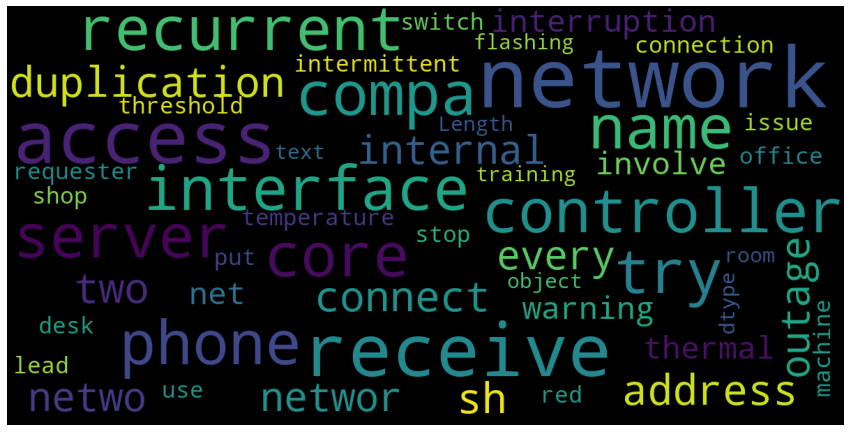

Word cloud for class  29


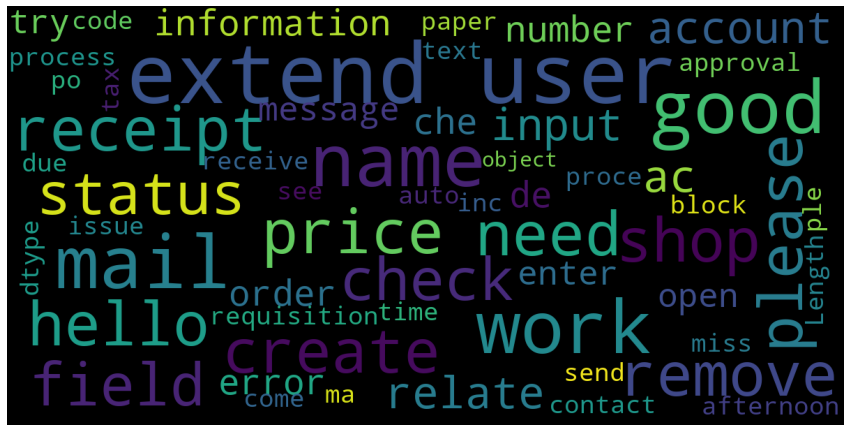

Word cloud for class  18


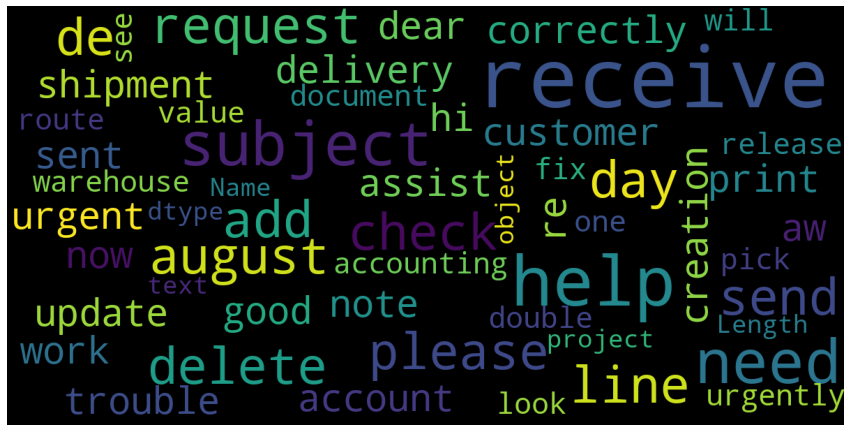

Word cloud for class  17


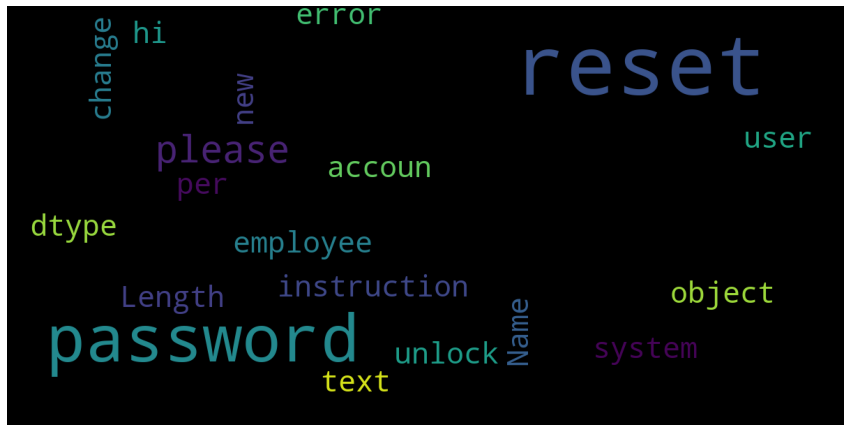

Word cloud for class  16


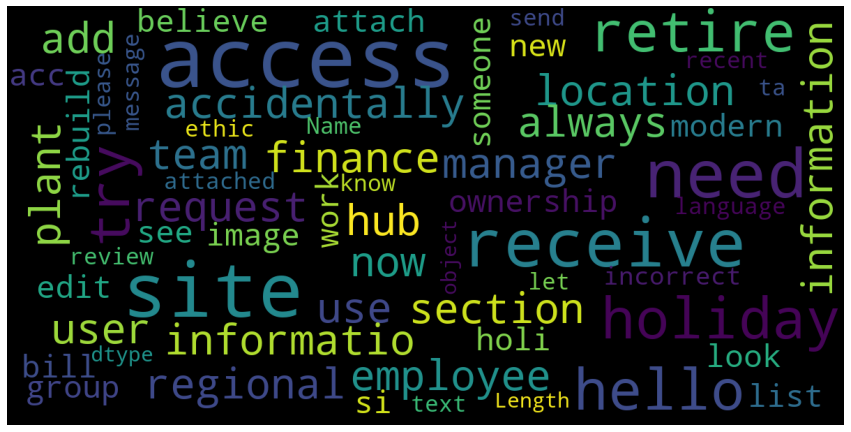

Word cloud for class  33


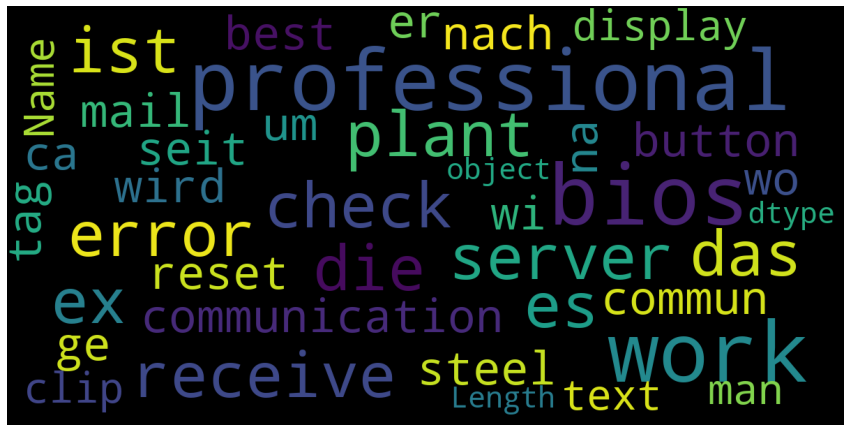

In [48]:
for i in top_20_grp.values:
  print("Word cloud for class ",i)
  show_wordcloud(df_sampled[df_sampled['Assignment group'] == i]['text'])

In [49]:
def plt_freq_words(all_lines):
  
  filtered_words = [word for word in all_lines.split() ]
  counted_words = collections.Counter(filtered_words)
  words = []
  counts = []
  for letter, count in counted_words.most_common(20):
      words.append(letter)
      counts.append(count)
  colors = cm.rainbow(np.linspace(0, 1, 20))
  rcParams['figure.figsize'] = 20, 10
  plt.title('Top words in the headlines vs their count')
  plt.xlabel('Count')
  plt.ylabel('Words')
  plt.barh(words, counts, color=colors)

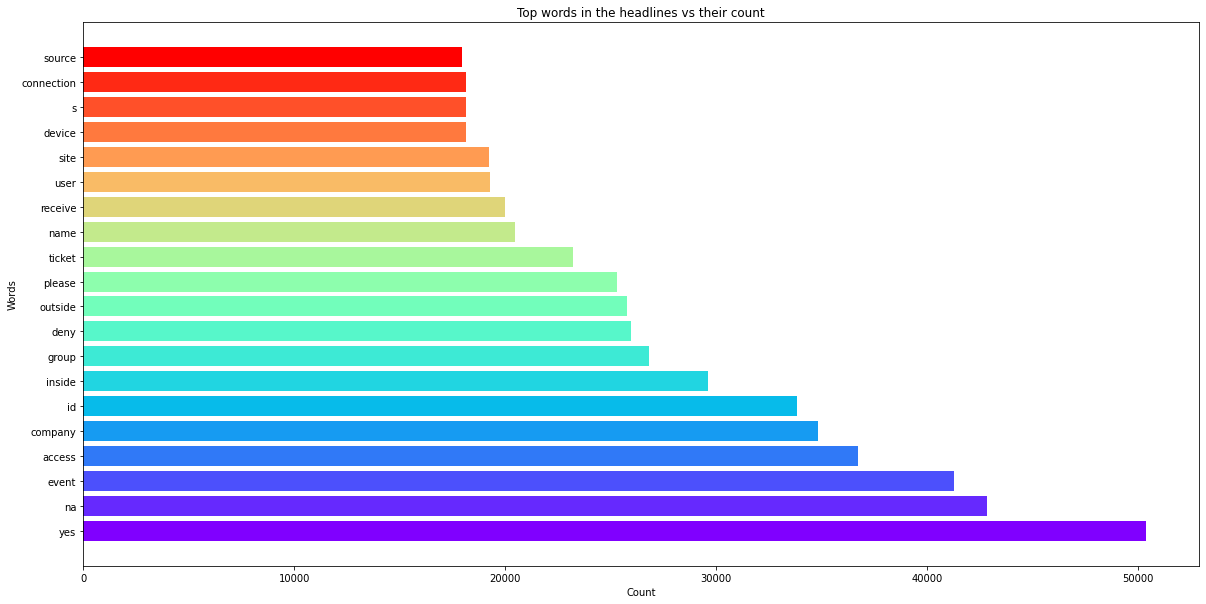

In [50]:
plt_freq_words( ' '.join(df_sampled['text'].str.lower()))

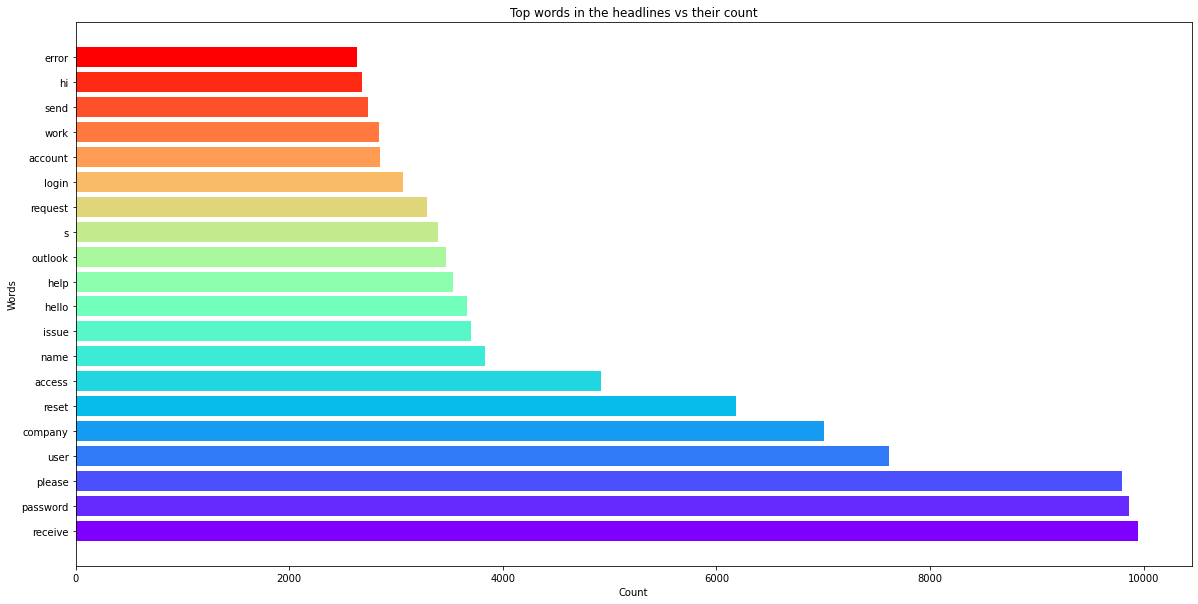

In [ ]:
plt_freq_words(' '.join(df_sampled[df_sampled['Assignment group'] == 0]['text'].str.lower()))

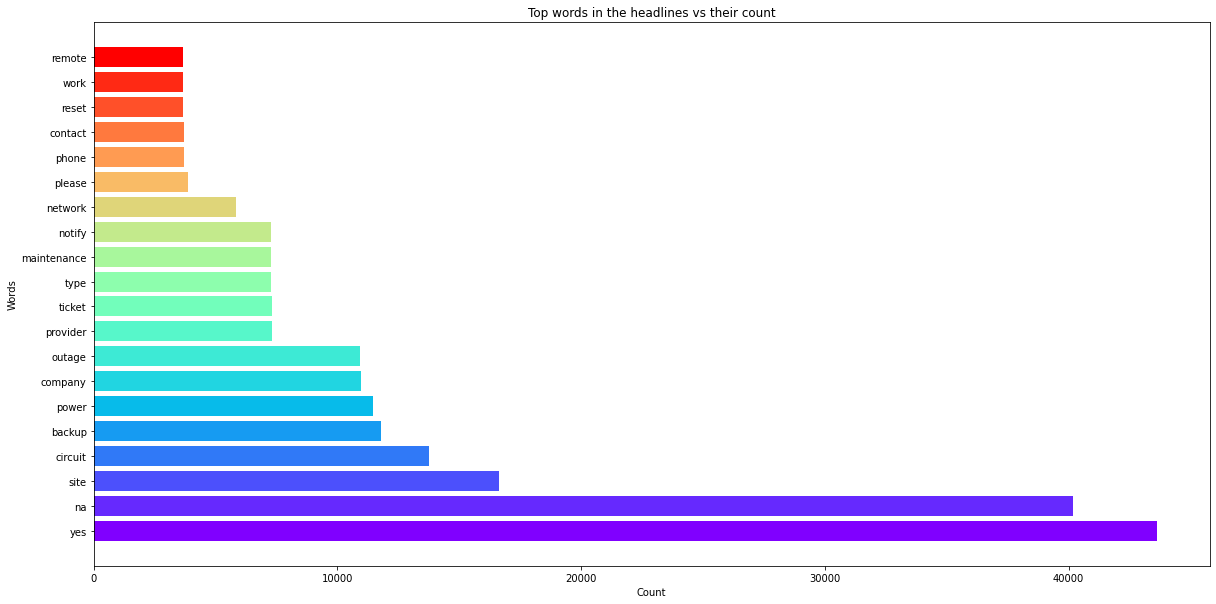

In [ ]:
plt_freq_words(' '.join(df_sampled[df_sampled['Assignment group'] == 8]['text'].str.lower()))

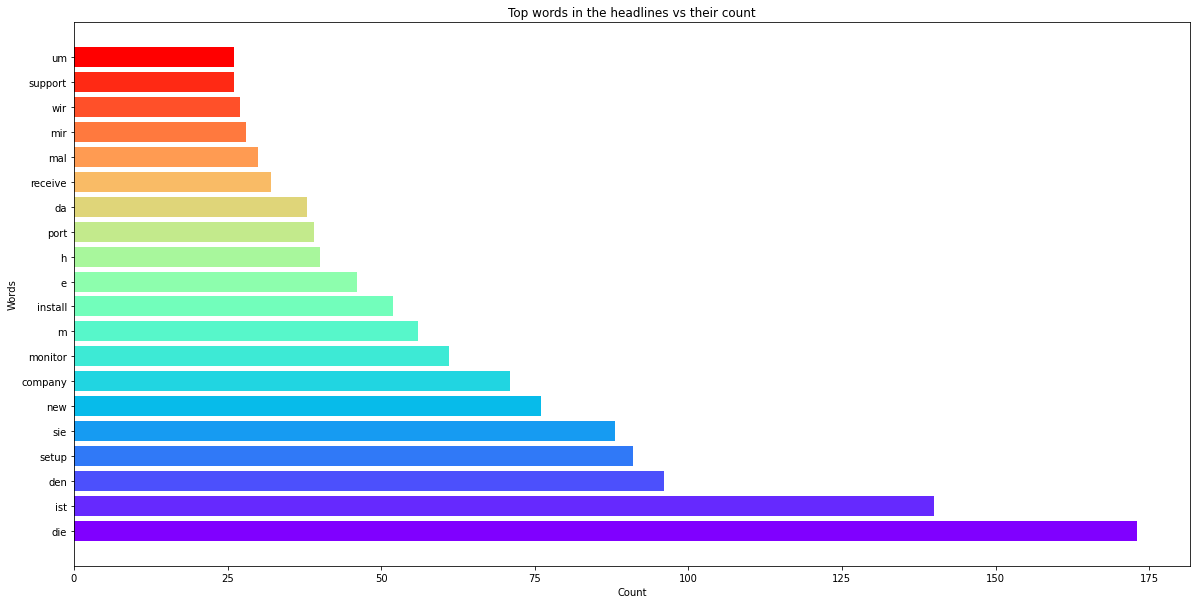

In [ ]:
plt_freq_words(' '.join(df_sampled[df_sampled['Assignment group'] == 24]['text'].str.lower()))

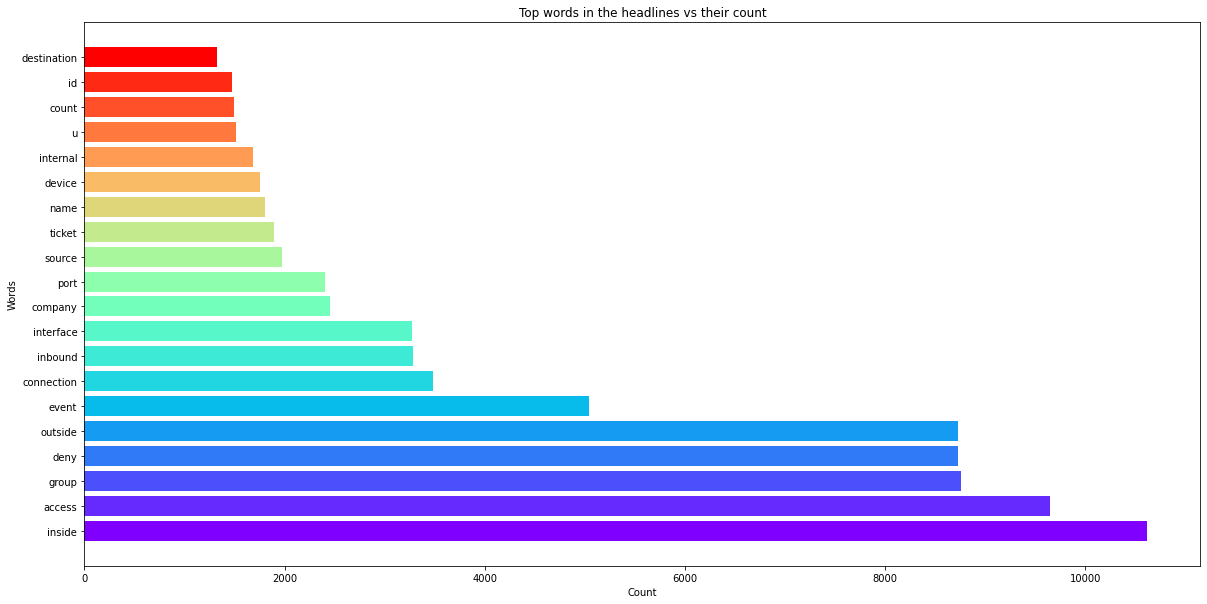

In [ ]:
plt_freq_words(' '.join(df_sampled[df_sampled['Assignment group'] == 12]['text'].str.lower()))

In [ ]:
lemmatize_words("revision in following goose")

'revision in follow goose'

In [ ]:
clean_sent("not lyxxy 1")

'not'

In [51]:
from collections import Counter
cnt = Counter()
for text in df_sampled[TEXT].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('yes', 50365),
 ('na', 42846),
 ('event', 41280),
 ('access', 36736),
 ('company', 34836),
 ('id', 33810),
 ('inside', 29588),
 ('group', 26813),
 ('deny', 25972),
 ('outside', 25786)]

6. Creating unigrams:
Let’s follow the steps below to create unigrams for the news column of the df_train data frame:

Create unigrams for each of the news records belonging to each of the three categories of sentiments

Store the word and its count in the corresponding dictionaries
Convert these dictionaries to corresponding data frames
Fetch the top 10 most frequently used words
Visualize the most frequently used words for all the 3 categories-positive, negative and neutral.
Have a look at the codes below to understand the steps better.
https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/

In [52]:
def generate_N_grams(text,ngram):
  words=[word for word in text.split(" ") if word not in STOPWORDS]  
  #print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [53]:
Grp0Values=defaultdict(int)
Grp8Values=defaultdict(int)
Grp24Values=defaultdict(int)
Grp12Values=defaultdict(int)
#get the count of every word in both the columns of df_train and df_test dataframes

In [54]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==0].text:
  for word in generate_N_grams(text,1):
    Grp0Values[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==8].text:
  for word in generate_N_grams(text,1):
    Grp8Values[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==24].text:
  for word in generate_N_grams(text,1):
    Grp24Values[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==12].text:
  for word in generate_N_grams(text,1):
    Grp12Values[word]+=1

In [ ]:
# Grp0Values=defaultdict(int)
# Grp8Values=defaultdict(int)
# Grp24Values=defaultdict(int)
# Grp12Values=defaultdict(int)
#focus on more frequently occuring words for every sentiment=>
#sort in DO wrt 2nd column in each of positiveValues,negativeValues and neutralValues
df_0Values=pd.DataFrame(sorted(Grp0Values.items(),key=lambda x:x[1],reverse=True))
df_8Values=pd.DataFrame(sorted(Grp8Values.items(),key=lambda x:x[1],reverse=True))
df_24Values=pd.DataFrame(sorted(Grp24Values.items(),key=lambda x:x[1],reverse=True))
df_12Values=pd.DataFrame(sorted(Grp12Values.items(),key=lambda x:x[1],reverse=True))

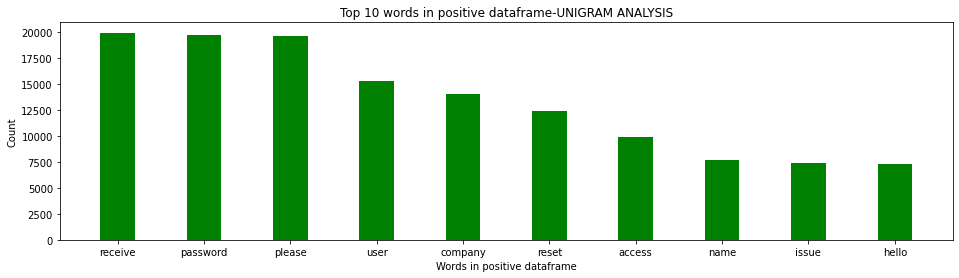

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_0Values[0][:10],df_0Values[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

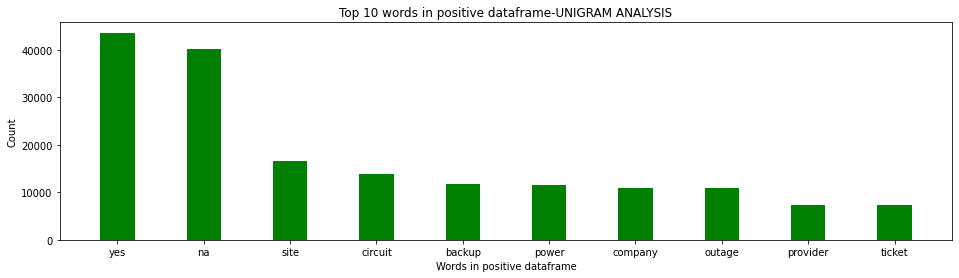

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_8Values[0][:10],df_8Values[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

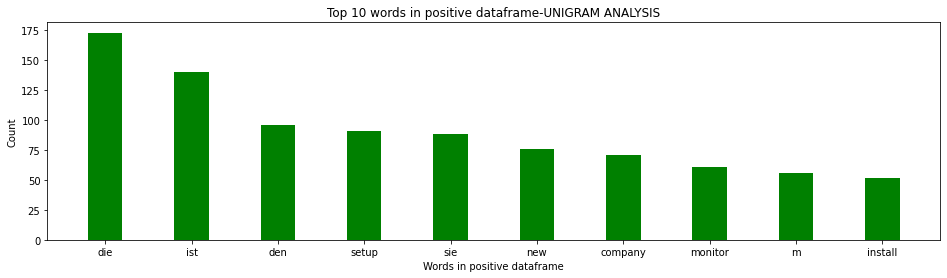

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_24Values[0][:10],df_24Values[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

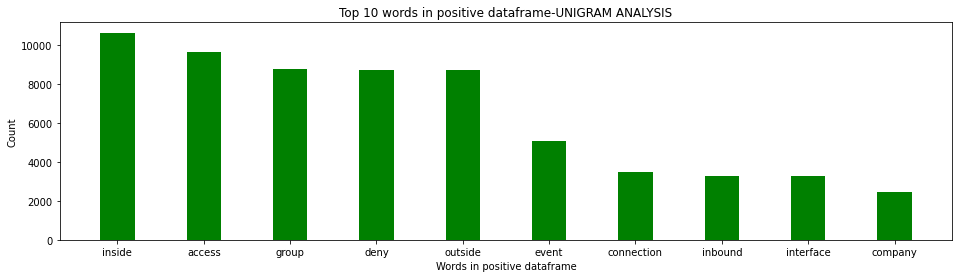

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_12Values[0][:10],df_12Values[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

7. Creating bigrams:
Repeat the same steps which we followed to analyze our data using unigrams except that you have to pass parameter 2 while invoking the generate_N_grams() function. You can optionally consider changing the names of the data frames, which I have done.

In [ ]:
Grp0Values_2=defaultdict(int)
Grp8Values_2=defaultdict(int)
Grp24Values_2=defaultdict(int)
Grp12Values_2=defaultdict(int)

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==0].text:
  for word in generate_N_grams(text,2):
    Grp0Values_2[word]+=1

In [ ]:
for text in df_sampled[df_sampled['Assignment group']==8].text:
  for word in generate_N_grams(text,2):
    Grp8Values_2[word]+=1

In [ ]:
for text in df_sampled[df_sampled['Assignment group']==24].text:
  for word in generate_N_grams(text,2):
    Grp24Values_2[word]+=1

In [ ]:
for text in df_sampled[df_sampled['Assignment group']==12].text:
  for word in generate_N_grams(text,2):
    Grp12Values_2[word]+=1

In [ ]:
df_0Values_2=pd.DataFrame(sorted(Grp0Values_2.items(),key=lambda x:x[1],reverse=True))
df_8Values_2=pd.DataFrame(sorted(Grp8Values_2.items(),key=lambda x:x[1],reverse=True))
df_24Values_2=pd.DataFrame(sorted(Grp24Values_2.items(),key=lambda x:x[1],reverse=True))
df_12Values_2=pd.DataFrame(sorted(Grp12Values_2.items(),key=lambda x:x[1],reverse=True))

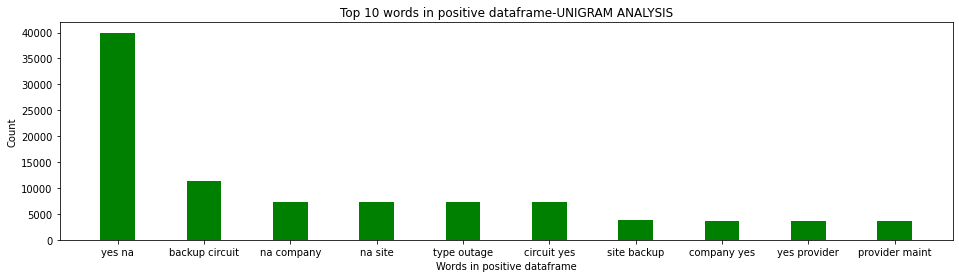

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_8Values_2[0][:10],df_8Values_2[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

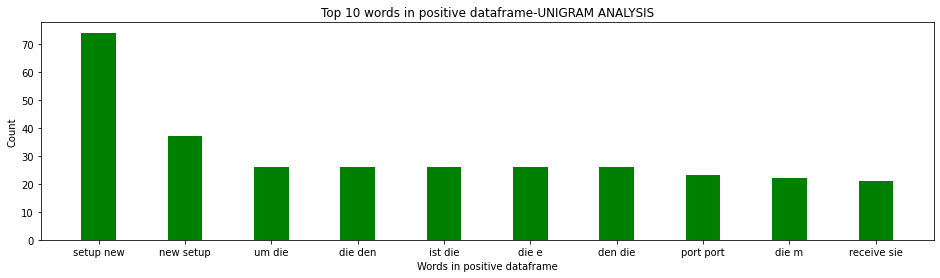

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_24Values_2[0][:10],df_24Values_2[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

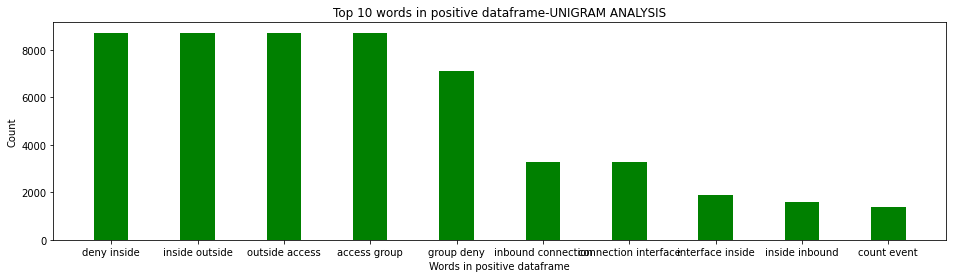

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_12Values_2[0][:10],df_12Values_2[1][:10], color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

In [ ]:
Grp0Values_3=defaultdict(int)
Grp8Values_3=defaultdict(int)
Grp24Values_3=defaultdict(int)
Grp12Values_3=defaultdict(int)

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==0].text:
  for word in generate_N_grams(text,3):
    Grp0Values_3[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==8].text:
  for word in generate_N_grams(text,3):
    Grp8Values_3[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==24].text:
  for word in generate_N_grams(text,3):
    Grp24Values_3[word]+=1

In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_sampled[df_sampled['Assignment group']==12].text:
  for word in generate_N_grams(text,3):
    Grp12Values_3[word]+=1

In [ ]:
df_0Values_3=pd.DataFrame(sorted(Grp0Values_3.items(),key=lambda x:x[1],reverse=True))
df_8Values_3=pd.DataFrame(sorted(Grp8Values_3.items(),key=lambda x:x[1],reverse=True))
df_24Values_3=pd.DataFrame(sorted(Grp24Values_3.items(),key=lambda x:x[1],reverse=True))
df_12Values_3=pd.DataFrame(sorted(Grp12Values_3.items(),key=lambda x:x[1],reverse=True))

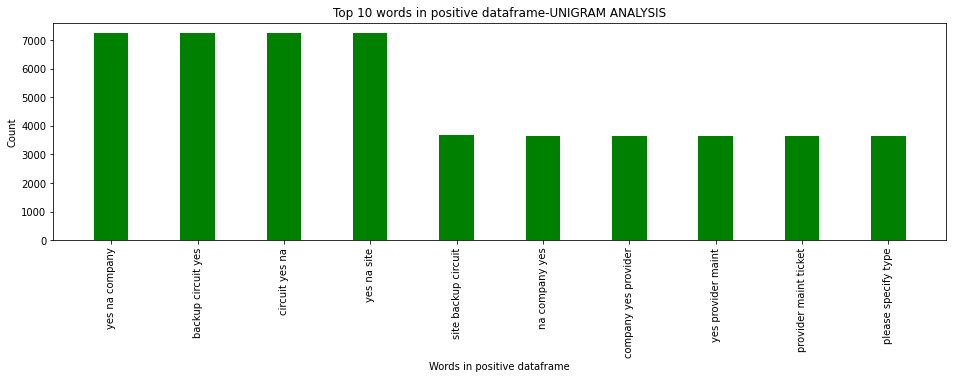

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_8Values_3[0][:10],df_8Values_3[1][:10], color ='green',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

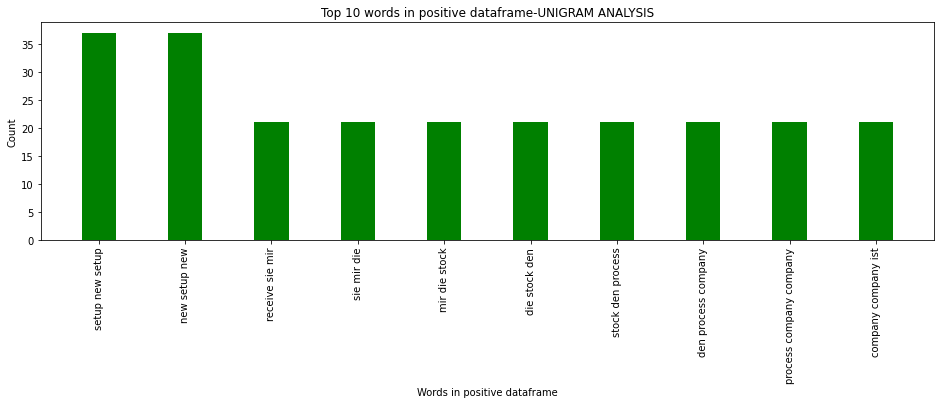

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_24Values_3[0][:10],df_24Values_3[1][:10], color ='green',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

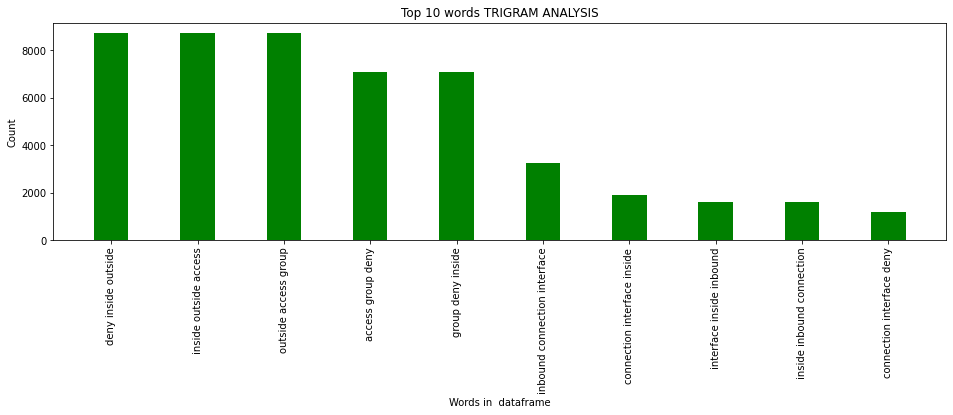

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(df_12Values_3[0][:10],df_12Values_3[1][:10], color ='green',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Words in  dataframe")
plt.ylabel("Count")
plt.title("Top 10 words TRIGRAM ANALYSIS")
plt.savefig("Trigram_12.png")
plt.show()


In [ ]:
df_sampled['Assignment group'].value_counts()

0     2737
8      656
12     248
9      245
2      227
24     199
6      184
3      158
19     154
13     141
10     134
5      129
14     112
25     102
4       96
29      92
18      85
17      81
16      81
33      75
Name: Assignment group, dtype: int64

In [55]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word as naw
#aug = nac.KeyboardAug()

In [ ]:
# aug = nac.KeyboardAug(name='Keyboard_Aug', aug_char_min=1, aug_char_max=10, aug_char_p=0.3, aug_word_p=0.3, 
#                       aug_word_min=1, aug_word_max=10, stopwords=None, tokenizer=None, reverse_tokenizer=None, 
#                       include_special_char=True, include_numeric=True, include_upper_case=True, lang='en', verbose=0, 
#                       stopwords_regex=None, model_path=None, min_char=4)

In [56]:
 aug = naw.SynonymAug()
 aug.augment("tomorrow is working day")

'tomorrow be work day'

In [57]:
from random import shuffle

In [58]:
def augment_text(df,samples,Grp_No):
    #aug_w2v.aug_p=pr
    #new_text=[]
    
    ##selecting the minority class samples
    df_n=df[df['Assignment group']==Grp_No].reset_index(drop=True)
    #print(len(df_n))

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
            #print(i)
            text = df_n.iloc[i]['text']
            #print(" text"+ text)
            new_text = aug.augment(text)
            #print(new_text+ "aug text" )
            #new_text.append(augmented_text)
            #print("donr")
            new=pd.DataFrame({'text':[new_text],'Assignment group':[Grp_No]})
            df_n=(df_n.append(new).reset_index(drop=True))
    
    
    ## dataframe
    
   
    return df_n

In [ ]:
# # model_type: word2vec, glove or fasttext
# aug_w2v = naw.WordEmbsAug(
# #     model_type='word2vec', model_path='../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin',
#     model_type='glove', model_path='/content/drive/MyDrive/Colab Notebooks/TextClassification/glove.6B.50d.txt',action="substitute")
# print("Original:")
# print(text)

4       96
29      92
18      85
17      81
16      81
33      75

In [61]:
df_grp_8 = augment_text(df_sampled,200,8)
df_grp_12 = augment_text(df_sampled,400,12)
df_grp_9 = augment_text(df_sampled,400,9)
df_grp_2 = augment_text(df_sampled,400,2)
df_grp_24 = augment_text(df_sampled,400,24)
df_grp_6 = augment_text(df_sampled,400,6)
df_grp_3 = augment_text(df_sampled,500,3)
df_grp_19 = augment_text(df_sampled,500,19)
df_grp_13 = augment_text(df_sampled,500,13)
df_grp_10 = augment_text(df_sampled,500,10)
df_grp_5 = augment_text(df_sampled,500,5)
df_grp_14 = augment_text(df_sampled,500,14)
df_grp_25 = augment_text(df_sampled,500,25)
df_grp_4 = augment_text(df_sampled,500,4)
df_grp_29 = augment_text(df_sampled,500,29)
df_grp_18 = augment_text(df_sampled,500,18)
df_grp_17 = augment_text(df_sampled,500,17)
df_grp_16 = augment_text(df_sampled,500,16)
df_grp_33 = augment_text(df_sampled,500,33)


100%|██████████| 500/500 [00:09<00:00, 54.99it/s]


In [59]:
df_grp_0 = df_sampled[df_sampled['Assignment group']==0].sample(1000)

In [ ]:
df_grp_0

text  Assignment group
1525                          account lock account lock                 0
3992                  outlook work nothing outlook work                 0
7563  password reset request user password reset req...                 0
1016  impact award receive ich das impact award mein...                 0
1623  receive solver application single sign portal ...                 0
...                                                 ...               ...
6726  work receive t make call t hear t hear work re...                 0
6585  now work receive hello always error limited co...                 0
16    unable login company receive company hi unable...                 0
3360          log balance error issue log balance error                 0
1260  re add receive company hello update re add rec...                 0

[1000 rows x 2 columns]

In [62]:
df_model = pd.concat([df_grp_8, df_grp_12, df_grp_9,df_grp_2,df_grp_24,df_grp_6,df_grp_3 ,df_grp_19,df_grp_13,df_grp_10,df_grp_5,df_grp_14,df_grp_25,df_grp_4,df_grp_29,df_grp_18,df_grp_17,df_grp_16,df_grp_33,df_grp_0 ])

In [63]:
df_model

text  Assignment group
0     job receive company job job receive company jo...                 8
1     job receive company job job receive company jo...                 8
2     job receive company job job receive company jo...                 8
3     company two company two company company access...                 8
4     job receive company job job receive company jo...                 8
...                                                 ...               ...
5002  help receive t enter need immediately please h...                 0
3678                          account lock account lock                 0
282   company private phone receive please help set ...                 0
5897  mein nun outlook problem outlook mein nun outl...                 0
4911  finish start s process receive territory direc...                 0

[12899 rows x 2 columns]

In [ ]:
len(df_model['Assignment group'].value_counts())

20

In [64]:
df_model = df_model.sample(frac = 1)

In [65]:
df_model['Assignment group']

169     6
452     6
425     4
208    13
52      8
       ..
256    17
589    10
190     6
150    33
172    10
Name: Assignment group, Length: 12899, dtype: int64

In [66]:
LABEL = 'Assignment group'

In [67]:
from sklearn.utils import class_weight

In [ ]:
len(df_model[TEXT]), len(df_model[LABEL])

(12899, 12899)

In [68]:
train_x, rem_x, train_y, rem_y = model_selection.train_test_split(df_model[TEXT], df_model[LABEL], random_state=42, stratify=df_model[LABEL], train_size=0.8)

In [69]:
valid_x, test_x, valid_y, test_y = model_selection.train_test_split(rem_x,rem_y, test_size=0.5,random_state=42)

In [ ]:
len(valid_x),len(test_x),len(valid_y),len(test_y)

(1290, 1290, 1290, 1290)

*Result df*

In [70]:
df_results = pd.DataFrame()

TypeError: ignored

In [79]:
def apply_pca (X):
  cov_matrix_1 = np.cov(X.T)
  #print("covariance matrix of part 2\n",cov_matrix_3)
  eigen_value_1, eigen_vector_1 = np.linalg.eig(cov_matrix_1)
  #how to find cumuative variance in PCA
  tol_1 = sum(eigen_value_1)
  var_eigen_value  = [(i/tol_1) * 100 for i in sorted(eigen_value_1,reverse = True)]

  cum_eigen_val = np.cumsum(var_eigen_value)
  #print("cumulative variance",cum_eigen_val)
  plt.plot(cum_eigen_val)
  return eigen_value_1,var_eigen_value,cum_eigen_val
  # ## plotting figure
  # plt.figure(figsize=(15,7))
  # plt.bar(range(1,eigen_value_1.size+1),var_eigen_value,align = 'center',label= "Eigen value - Individual variance",alpha = 0.5)
  # plt.step(range(1,eigen_value_1.size+1),cum_eigen_val, alpha = 0.8,where = 'mid',label = 'Cumulative variance')
  # plt.xlabel("principal components")
  # plt.ylabel("explained variance")
  # plt.axhline(y = 99, color = 'r', linestyle = '--')
  # plt.axvline(x = 170, color = 'r', linestyle = '--')

  # plt.axhline(y = 98, color = 'g', linestyle = '--')
  # plt.axvline(x = 160, color = 'g', linestyle = '--')

  # plt.axhline(y = 95, color = 'k', linestyle = '--')
  # plt.axvline(x = 140, color = 'k', linestyle = '--')

  # plt.tight_layout()
  # plt.show()


In [71]:
def apply_count_vect(xtrain,xvalid,xtest):
  count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
  count_vect.fit(xtrain)

  # transform the training and validation data using count vectorizer object
  xtraincount =  count_vect.transform(xtrain).toarray()
  xvalidcount =  count_vect.transform(xvalid).toarray()
  xtestcount =   count_vect.transform(xtest).toarray()
  return xtraincount,xvalidcount,xtestcount

In [78]:
def apply_tf_idf_vect(xtrain,xvalid,xtest):
  tfidf_vect = TfidfVectorizer(ngram_range = (1,3))
  tfidf_vect.fit(xtrain)
  # word level tf-idf
  #tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
  tfidf_vect_train =  tfidf_vect .transform(xtrain)
  tfidf_vect_val =  tfidf_vect .transform(xvalid)
  tfidf_vect_test =   tfidf_vect .transform(xtest)
  return tfidf_vect_train.toarray(),tfidf_vect_val.toarray(),tfidf_vect_test.toarray()

In [77]:
def fit_pca(n_component,x_train,x_test,x_val):
  pca_1 = PCA(n_components = n_component, random_state = 1)
  pca_1.fit(x_train)
  x_train_pca = pca_1.fit_transform(x_train)
  x_test_pca = pca_1.transform(x_test)
  x_valid_pca = pca_1.transform(x_val)
  return x_train_pca,x_test_pca,x_valid_pca

In [ ]:
def fit_tokenizer(xtrain,xvalid,xtest):
  token = Tokenizer()
  token.fit_on_texts(xtrain)
  word_index = token.word_index

  # convert text to sequence of tokens and pad them to ensure equal length vectors 
  train_seq = sequence.pad_sequences(token.texts_to_sequences(xtrain), maxlen=300)
  valid_seq = sequence.pad_sequences(token.texts_to_sequences(xvalid), maxlen=300)
  test_seq = sequence.pad_sequences(token.texts_to_sequences(xtest)), maxlen=300)
  return train_seq,valid_seq,test_seq

One-Hot encoding (CountVectorizing)

In [80]:
%%time
# create a count vectorizer object 
# count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
# count_vect.fit(train_x)

# # transform the training and validation data using count vectorizer object
# xtrain_count =  count_vect.transform(train_x).toarray()
# xvalid_count =  count_vect.transform(valid_x).toarray()
# xtest_count =   count_vect.transform(test_x).toarray()
xtrain_count,xvalid_count,xtest_count =  apply_count_vect(train_x,valid_x,test_x)

CPU times: user 4.69 s, sys: 877 ms, total: 5.57 s
Wall time: 5.58 s


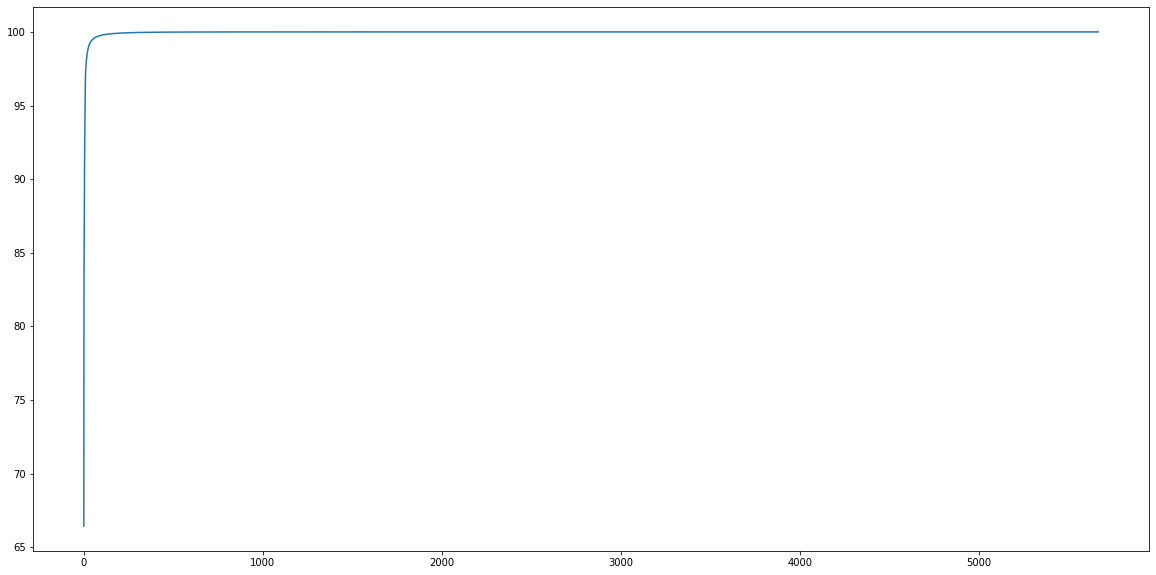

In [83]:
eigen_value_count,var_eigen_value_count,cum_eigen_val_count = apply_pca(xtrain_count)

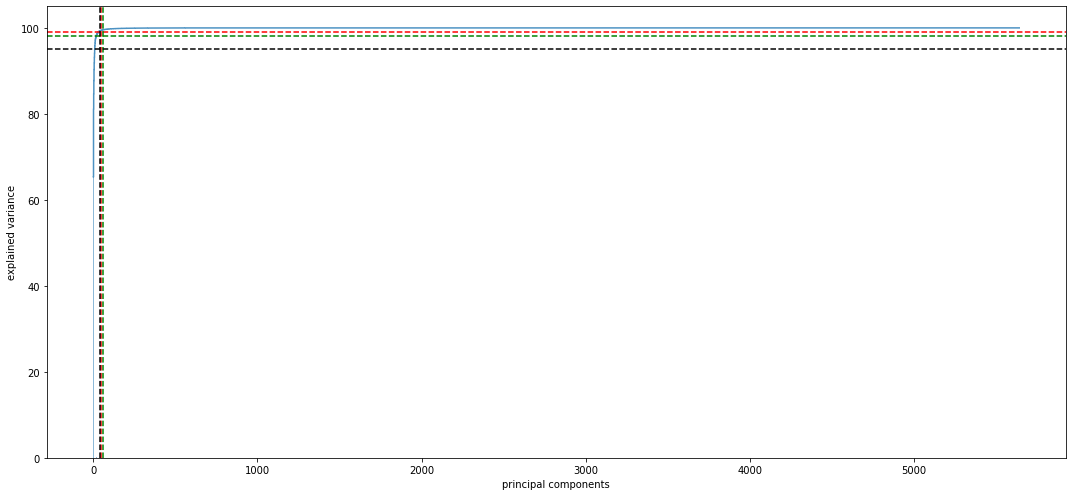

In [ ]:
plt.figure(figsize=(15,7))
plt.bar(range(1,eigen_value_count.size+1),var_eigen_value_count,align = 'center',label= "Eigen value - Individual variance",alpha = 0.5)
plt.step(range(1,eigen_value_count.size+1),cum_eigen_val_count, alpha = 0.8,where = 'mid',label = 'Cumulative variance')
plt.xlabel("principal components")
plt.ylabel("explained variance")
plt.axhline(y = 99, color = 'r', linestyle = '--')
plt.axvline(x = 50, color = 'r', linestyle = '--')

plt.axhline(y = 98, color = 'g', linestyle = '--')
plt.axvline(x = 60, color = 'g', linestyle = '--')

plt.axhline(y = 95, color = 'k', linestyle = '--')
plt.axvline(x = 40, color = 'k', linestyle = '--')

plt.tight_layout()
plt.show()

In [2]:
x_train_pca_count,x_test_pca_count,x_valid_pca_count = fit_pca(50,xtrain_count,xtest_count,xvalid_count)

NameError: ignored

In [1]:
tfidf_vect_train_count,tfidf_vect_val_count,tfidf_vect_test_count =  apply_tf_idf_vect(train_x,valid_x,test_x)


NameError: ignored

In [ ]:
%%time
tfidf_vect = TfidfVectorizer(ngram_range = (1,3))
tfidf_vect.fit(train_x)
# word level tf-idf
#tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_train_count =  tfidf_vect .transform(train_x).toarray()
tfidf_vect_val_count =  tfidf_vect .transform(valid_x).toarray()
tfidf_vect_test_count =   tfidf_vect .transform(test_x).toarray()

CPU times: user 17.1 s, sys: 159 ms, total: 17.2 s
Wall time: 17.2 s


In [ ]:
xtrain_count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
tfidf_vect_train_count.toarray()

NameError: ignored

In [ ]:
eigen_value_tfidf_vect,var_eigen_value_tfidf_vect,cum_eigen_val_tfidf_vect = apply_pca(tfidf_vect_train_count)

AttributeError: ignored

Word Embedding

In [ ]:
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(train_x)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen=300)

In [ ]:
train_seq_x

array([[   0,    0,    0, ...,    0,  295, 3140],
       [   0,    0,    0, ...,   22,    9,   87],
       [   0,    0,    0, ...,   10,  894,    2],
       ...,
       [   0,    0,    0, ...,  287,  525,   59],
       [   0,    0,    0, ...,   22,    9,   87],
       [   0,    0,    0, ..., 2698, 1997,  273]], dtype=int32)

In [ ]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [ ]:
import pickle

In [ ]:
# Dict of metrics to use in the model selection
score_metrics = {'acc': accuracy_score,
               #'balanced_accuracy': balanced_accuracy_score,
               #'prec': precision_score,
               #'recall': recall_score,
               'f1-score': f1_score,
               #'tp': tp, 'tn': tn,
               #'fp': fp, 'fn': fn,
               #'cohens_kappa':cohen_kappa_score,
               #'matthews_corrcoef':matthews_corrcoef,
               #"roc_auc":roc_auc_score
               }

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score    

In [ ]:
def report(clf, x, y, name='classifier', cv=5, dict_scoring=None, fit_params=None):
    #print(dict_scoring)
    if dict_scoring!=None:
        score = dict_scoring.copy()
        for i in score.keys():
            print(i)
            print(make_scorer(score[i]))
            score[i] = make_scorer(score[i])
            
#             score[i] = score[i]
#             print(score[i])
            # if i == 'f1-score':
            #     print("f1")
            #     score[i] = make_scorer(precision_score, average = 'weighted')
            #     print( make_scorer(sklearn.metrics.f1_score, average = 'weighted'))
            if i == 'f1-score':
                score[i] = make_scorer(sklearn.metrics.f1_score, average = 'weighted')
            # if i== 'acc':
            #     score[i] = make_scorer(sklearn.metrics.accuracy_score, average = 'weighted')
            # if i== 'prec':
            #     score[i] = make_scorer(sklearn.metrics.precision_score, average = 'weighted')
            # if i== 'recall':
            #     score[i] = make_scorer(sklearn.metrics.recall_score, average = 'weighted')
                
           
    score = {'accuracy': make_scorer(accuracy_score),          
             #'prec':  make_scorer(average_precision_score, average = 'weighted')
            'f1-score':  make_scorer(sklearn.metrics.f1_score, average = 'weighted'),
            'precision_score':  make_scorer(sklearn.metrics.precision_score, average = 'weighted'),
            'recall_score':  make_scorer(sklearn.metrics.recall_score, average = 'weighted')
    }
    #scorer = make_scorer(average_precision_score, average = 'weighted')
    #if clf==XGBClassifier():

    scores = model_selection.cross_validate(clf, x, y.values, scoring=score,
                         cv=cv, n_jobs=-1,  fit_params=fit_params)
    #print(scores)
    model_name = name+"_model"
    model_name = clf.fit (x, y)
    pickle.dump(model_name, open(name+"_model", 'wb'))
  
    
#     scorestest = cross_validate(clf, x, y, scoring='f1_macro',
#                          cv=cv, return_train_score=False, n_jobs=-1,  fit_params=fit_params)
#   cross_val_score(dec_tree, X, y, scoring="f1", cv = 7)
    print("pickled model")
    index = []
    value = []
    index.append("Model")
    value.append(name)
    for i in scores:
        if i == "estimator":
            continue
        for j in enumerate(scores[i]):
            index.append(i+"_cv"+str(j[0]+1))
            value.append(j[1])
        #if any(x in i for x in scoring.keys()):
        
        index.append(i+"_mean")
        value.append(np.mean(scores[i]))
        index.append(i+"_std")
        value.append(np.std(scores[i]))
        print(i,np.mean(scores[i]))
        
    return pd.DataFrame(data=value, index=index).T

In [ ]:
df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_count,train_y, name='NB_Count_Vectors', cv=5, dict_scoring=score_metrics))
df_results = df_results.append(report(naive_bayes.MultinomialNB(), tfidf_vect_train_count,train_y, name='NB_TF-IDF', cv=5, dict_scoring=score_metrics))
df_results = df_results.append(report(naive_bayes.MultinomialNB(), train_seq_x,train_y, name='NB_seq', cv=5, dict_scoring=score_metrics))
# df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars,train_y, name='NB_CharLevel_TF-IDF', cv=5, dict_scoring=score_metrics))
# df_results = df_results.append(report(naive_bayes.MultinomialNB(), train_seq_x,train_y, name='NB_Words', cv=5, dict_scoring=score_metrics))

acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 12.631070995330811
score_time 0.0894768238067627
test_accuracy 0.5266007394965562
test_f1-score 0.5048433082878007
test_precision_score 0.588829317211994
test_recall_score 0.5266007394965562
acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 0.2005373001098633
score_time 0.03840923309326172
test_accuracy 0.7521070297264087
test_f1-score 0.7543880818622781
test_precision_score 0.8164871196755223
test_recall_score 0.7521070297264087
acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 0.6504763603210449
score_time 0.01416325569152832
test_accuracy 0.11357735216644685
test_f1-score 0.08015434850469336
test_precision_score 0.19236753749286567
test_recall_score 0.11357735216644685


In [ ]:
df_results


Model fit_time_cv1  ... test_recall_score_mean test_recall_score_std
0  NB_Count_Vectors    14.167423  ...               0.526601              0.004696
0         NB_TF-IDF      0.21849  ...               0.752107              0.008225
0            NB_seq     0.733235  ...               0.113577              0.005673
0  NB_Count_Vectors   832.747971  ...               0.782924              0.006356
0         NB_TF-IDF   107.007489  ...               0.758891              0.003789
0            NB_seq    81.642731  ...               0.192654              0.007484

[6 rows x 43 columns]

Logistic Regression

In [ ]:
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_count,train_y, name='NB_Count_Vectors', cv=5, dict_scoring=score_metrics))
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), tfidf_vect_train_count,train_y, name='NB_TF-IDF', cv=5, dict_scoring=score_metrics))
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), train_seq_x,train_y, name='NB_seq', cv=5, dict_scoring=score_metrics))
# df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars,train_y, name='NB_CharLevel_TF-IDF', cv=5, dict_scoring=score_metrics))
# df_results = df_results.append(report(naive_bayes.MultinomialNB(), train_seq_x,train_y, name='NB_Words', cv=5, dict_scoring=score_metrics))

acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 751.6045820236207
score_time 0.10514535903930664
test_accuracy 0.7829242241486207
test_f1-score 0.7812775422218295
test_precision_score 0.792250152060673
test_recall_score 0.7829242241486207
acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 100.977698469162
score_time 0.03953375816345215
test_accuracy 0.7588911027441785
test_f1-score 0.7562123636388062
test_precision_score 0.7708136527480095
test_recall_score 0.7588911027441785
acc
make_scorer(accuracy_score)
f1-score
make_scorer(f1_score)
pickled model
fit_time 81.42734045982361
score_time 0.02733273506164551
test_accuracy 0.1926543060268218
test_f1-score 0.1722402269869898
test_precision_score 0.18208331056899385
test_recall_score 0.1926543060268218


XGBoost

In [ ]:
fit_params={'early_stopping_rounds':10,'eval_set':[(xvalid_count, valid_y)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_count,train_y, name='XGB_Count_Vectors', cv=5, fit_params=fit_params, dict_scoring=score_metrics))

acc
{'acc': make_scorer(accuracy_score)}
{'fit_time': array([107.30243468, 108.7561872 ,  59.64880538,  82.67751956,
        42.82330513]), 'score_time': array([0.84106922, 0.76846409, 0.43979478, 0.62094402, 0.29441166]), 'test_acc': array([0.7374031 , 0.74127907, 0.6996124 , 0.73013566, 0.69316529])}
fit_time 80.241650390625
score_time 0.5929367542266846
test_acc 0.7203191051640758


In [ ]:
fit_params={'early_stopping_rounds':5,'eval_set':[(tfidf_vect_val_count, valid_y)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=10, subsample=0.8), tfidf_vect_train_count,train_y, name='XGB_TF_IDF', cv=5, fit_params=fit_params, dict_scoring=score_metrics))

acc
{'acc': make_scorer(accuracy_score)}


In [ ]:
df_results

Model fit_time_cv1  ... test_acc_mean test_acc_std
0   NB_Count_Vectors     0.012425  ...      0.517976     0.010973
0          NB_TF-IDF     0.148953  ...      0.751429     0.008793
0             NB_seq     0.682709  ...      0.107279     0.007605
0   NB_Count_Vectors    55.619527  ...      0.780405     0.008095
0          NB_TF-IDF     78.61729  ...       0.75957     0.011217
0             NB_seq    66.240352  ...      0.185386     0.005787
0  XGB_Count_Vectors   107.302435  ...      0.720319     0.019968

[7 rows x 22 columns]

In [ ]:

fit_params={'early_stopping_rounds':10,'eval_set':[(valid_seq_x, valid_y)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), train_seq_x,train_y, name='XGB_seq', cv=5, fit_params=fit_params, dict_scoring=score_metrics))